In [1]:
import numpy as np
from image_alignment import ImageAligner
from datalib import *
from skimage import io
import os
from scipy.ndimage import gaussian_filter

wavelength_to_index = lambda x, wavelengths: np.argmin( np.abs( wavelengths - x ) )

In [2]:
%load_ext autoreload

In [3]:
%autoreload 1
%autoreload 2

# 1. Load the two modalities

## 1.1 LIBS

In [4]:
file_libs_metadata = r'E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma/LIBS/Kopie souboru 403x540-P36B-Avantes.libsmetadata.txt'
file_libs_data = r"E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma/LIBS/Kopie souboru 403x540-P36B-Avantes.libsdata"

libs_manipulator = MapData(file_path = file_libs_data)
libs_manipulator.load_wavelenths()
libs_manipulator.load_all_data('libs')
libs_manipulator.baseline_correct()

libs_manipulator.get_map_dimensions()
nx, ny = libs_manipulator.map_dimensions
spectrum = libs_manipulator.spectra.reshape(ny, nx, -1)
wavelengths = libs_manipulator.wvl

# Correct flipped dimensions
spectrum[1::2, :] = spectrum[1::2, ::-1]

loading wavelengths
loading metadata
preprocessed file was not found; setting overwrite to True
loading raw data
getting baselines
getting map dimensions


In [5]:
modality1 = spectrum[::-1, :, wavelength_to_index(266.106, wavelengths)].T

## 1.2 Optical

In [6]:
main_dir = r"E:/Data/Data_LIBS/Data_Brno/"
sample_dir = r"P36 - Epithelioid angiosarcoma//"
dir_image = main_dir + sample_dir + r"Histology//"

def read_image(folder, index = 0):
    files = [folder + '//' + f for f in os.listdir(folder) if f.endswith('jpg')]
    return io.imread(files[index])

sample_image = read_image(dir_image)

In [7]:
modality2 = sample_image[:, 285:1420, 0]

# 2. Align

In [8]:
# Downsample and Apply Gaussian Filter to reduce noise
step_mod1 = 4
mod1 = gaussian_filter(modality1[::step_mod1, ::step_mod1], sigma = 0.5)

step_mod2 = 8
mod2 = gaussian_filter(modality2[::step_mod2, ::step_mod2], sigma  = 0.5)

## 2.1 Manual Alingment

In [9]:
aligner = ImageAligner(mod1, mod2, device = 'cpu')

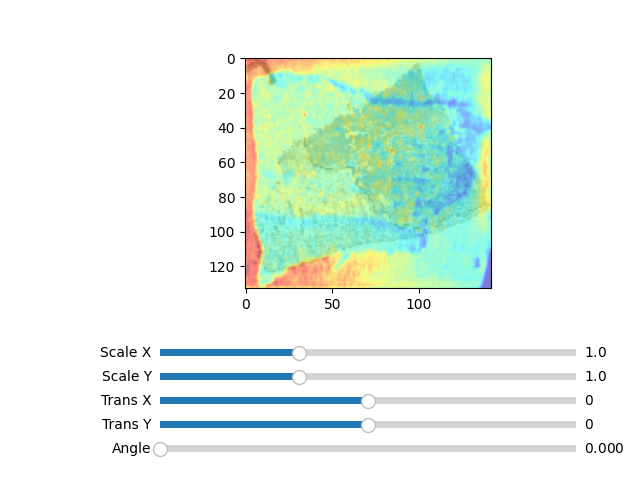

Initial alignment parameters: {'scale_x': 1.0, 'scale_y': 1.0, 'translate': [0.0, 0.0], 'rot_angle': 0.0}


In [11]:
%matplotlib widget
initial_params = aligner.manual_align()
print("Initial alignment parameters:", initial_params)

## 2.2 Automatic Fine Tuning

In [43]:
optimizer_params = {
    'optim': 'SGD',
    'lr': 1e-3,
    'momentum': 0.8,
    'num_iters': 500,
}

transform_params = {
    's_tol': 0.2,
    't_tol': 0.2,
    'a_tol': 0.2,
    'edge_align': True
}

In [44]:
final_params = aligner.auto_align(optimizer_params, transform_params)
print("Final alignment parameters:", final_params)

Final alignment parameters: {'rot_angle': 2.712923049926758, 'translate': [-0.10151813179254532, 0.09810290485620499], 'scale_x': 1.0027189254760742, 'scale_y': 0.7644795179367065}


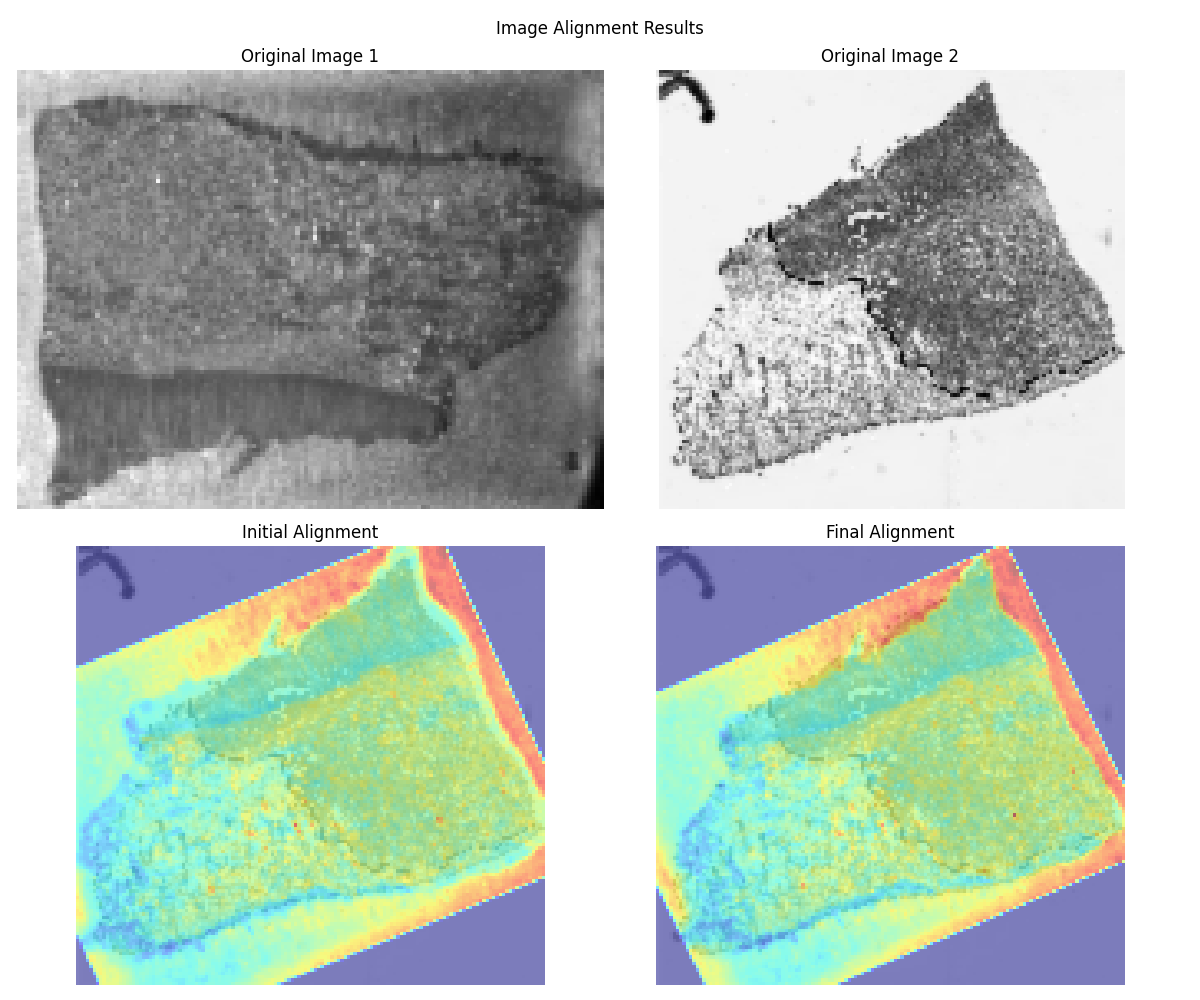

In [45]:
aligner.plot_alignment()